# Patchwise Training & Prediction

Environmental data can sometimes span large spatial areas. For example:

- Modelling tasks based on data that span the entire globe
- Modelling tasks with high-resolution data

In such cases, training and inference with a ConvNP over the entire region of data may be computationally prohibitive. However, we can resort to patchwise training, where the `TaskLoader` does not provide data of the entire region but instead creates smaller patches that are computationally feasible.

The goal of the notebook is to demonstrate patchwise training and inference.

In [1]:
import logging

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import (
    get_era5_reanalysis_data,
    get_earthenv_auxiliary_data,
    get_gldas_land_mask,
)

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
verbose_download = True

In [3]:
era5_raw_ds = get_era5_reanalysis_data(
    era5_var_IDs,
    extent,
    date_range=data_range,
    cache=True,
    cache_dir=cache_dir,
    verbose=verbose_download,
    num_processes=8,
)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(
    lowres_auxiliary_var_IDs,
    extent,
    "100KM",
    cache=True,
    cache_dir=cache_dir,
    verbose=verbose_download,
)
land_mask_raw_ds = get_gldas_land_mask(
    extent, cache=True, cache_dir=cache_dir, verbose=verbose_download
)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor(
    [lowres_aux_raw_ds, land_mask_raw_ds], method="min_max"
)

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

  0%|          | 0/120 [02:54<?, ?it/s]


KeyboardInterrupt: 

In [4]:
set_gpu_default_device()

## Initialise TaskLoader and ConvNP model

In [5]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [6]:
# Set up model
model = ConvNP(data_processor, task_loader, unet_channels=(32, 32, 32, 32, 32))

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.0012499999720603228, 0.0012499999720603228, 0.00416666641831398]
decoder_scale inferred from TaskLoader: 0.0025


## Define how Tasks are generated

For the purpose of this notebook, we will use a random patchwise training strategy for our training tasks and a sliding window patch strategy for validation and testing to make sure we cover the entire region of interest.

There are two possible arguments for patch_strategy: 
- `random`: where the centroid of the patches are randomly selected;
- `sliding_window`: where the patch is first produced in the top-left corner, and the patch is convolved from left to right and top to bottom over the whole image. 

If no patching strategy is defined, the default is for no patching to take place during training or inference. 

Additional arguments to define when running patchwise training: 
- `patch_size`: In x1 and x2 coordinate. This is required for both patching stategies
- `stride`: the distance in x1 and x2 between each patch. It is commonplace to use a stride size equal to half the patch size. This is only required when using `sliding_window`.
- `num_sample_per_date`: the number of patches to generate when using the random patching strategy.  

In [9]:
def gen_training_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        tasks_per_date = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling="all",
            patch_strategy="random",
            patch_size=(0.4, 0.4),
            num_samples_per_date=2,
        )
        tasks.extend(tasks_per_date)
    return tasks


def gen_validation_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        tasks_per_date = task_loader(
            date,
            context_sampling=["all", "all", "all"],
            target_sampling="all",
            patch_strategy="sliding",
            patch_size=(0.5, 0.5),
            stride=(0.25,0.25)
        )
        tasks.extend(tasks_per_date)
    return tasks

## Generate validation tasks for testing generalisation

In [10]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
val_tasks = gen_validation_tasks(val_dates)

  0%|          | 0/183 [00:00<?, ?it/s]

## Training with the Trainer class

In [11]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [12]:
num_epochs = 10
losses = []
val_rmses = []

# Train model
val_rmse_best = np.inf
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(num_epochs)):
    train_tasks = gen_training_tasks(pd.date_range(train_range[0], train_range[1])[::date_subsample_factor], progress=True)
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))
    val_rmses.append(compute_val_rmse(model, val_tasks))
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]
        model.save(deepsensor_folder)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

  0%|          | 0/1644 [00:00<?, ?it/s]

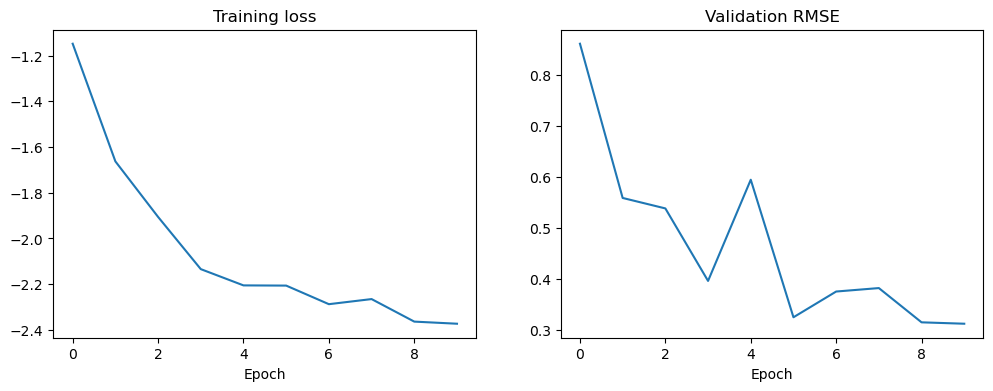

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

## Patching during inference

In many circumstances, patching is only required during training. If required during inference, use the `model.predict_patch()` function rather than `model.predict()`. 

Firstly, make the test tasks, defining the patch and stride size. The `sliding_window` strategy is the only strategy that can be used during inference. 
You must also pass in the `data_processor` when calling `model.predict_patch()`, alongside the `test_task` and `X_t`.

The `patch_predict()` function stitches the patchwise predictions together, to generate a prediction with the same original extent as X_t. Currently patches are stiched together by clipping the overlapping edges of the patches and concatenating them. We welcome contributions to add additional stitching strategies into the DeepSensor package. 

The output prediction object is identical to the object generated when running `model.predict()`. 

In [15]:
### Make prediction ###
test_date ="2019-01-01"
test_task = task_loader(test_date, context_sampling="all", target_sampling="all",
                        patch_strategy="sliding", patch_size=(0.5, 0.5), stride=(0.25, 0.25))
prediction = model.predict_patch(test_task, X_t=era5_raw_ds, data_processor = data_processor)
